# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import random
from scipy.stats import bernoulli, multivariate_normal
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
import time 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from joblib import Parallel, delayed
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
import warnings
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.model_selection._search")
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


# Synthetic Dataset

### Data 1

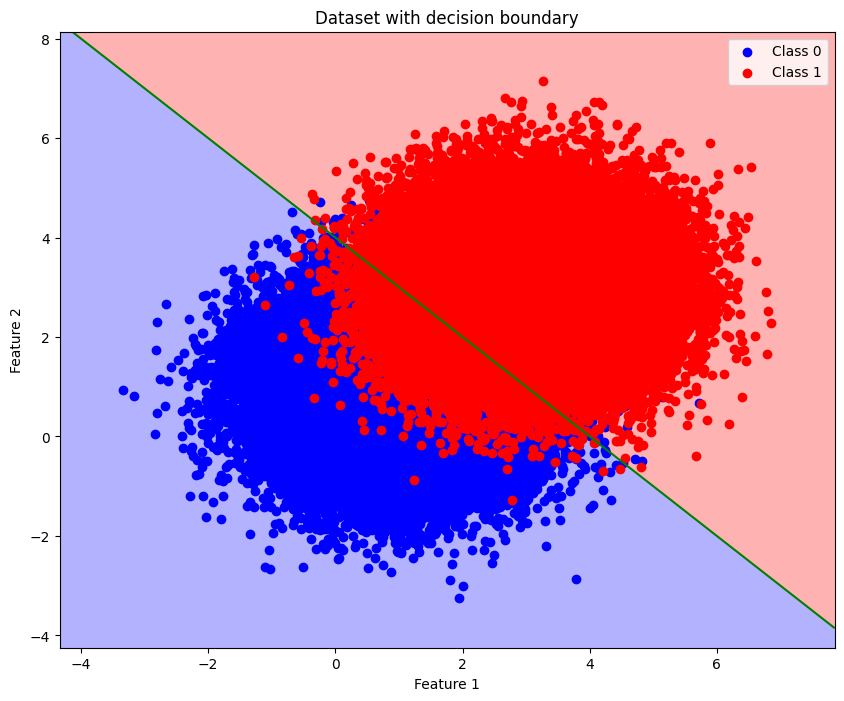

In [2]:
def eta1(x,p=1/2,mean0=np.array([1,1]), mean1=np.array([3,3]), cov0=np.array([[1, 0], [0, 1]]), cov1=np.array([[1, 0], [0, 1]])):
    eta= p * multivariate_normal.pdf(x, mean=mean1, cov=cov1) / ((p * multivariate_normal.pdf(x, mean=mean1, cov=cov1) + (1 - p) * multivariate_normal.pdf(x, mean=mean0, cov=cov0)))
    return eta


def generate_data(n_samples=100000, n_features=2, mean0=np.array([1,1]), mean1=np.array([3,3]), cov0=np.array([[1, 0], [0, 1]]), cov1=np.array([[1, 0], [0, 1]])):
    Y = bernoulli.rvs(0.5, size=n_samples)
    X = np.zeros((n_samples, n_features))
    
    
    for i in range(n_samples):
        if Y[i] == 0:
            X[i, :] = multivariate_normal.rvs(mean=mean0, cov=cov0)
        else:
            X[i, :] = multivariate_normal.rvs(mean=mean1, cov=cov1)
    
    return X, Y




X, Y = generate_data()


x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]


Z = np.array([eta1(point) for point in grid])
Z = Z.reshape(xx.shape)


plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3, colors=['blue', 'red'])
plt.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='red', label='Class 1')
plt.contour(xx, yy, Z, levels=[0.5], colors='green')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Dataset with decision boundary')
plt.show()

### Data 2

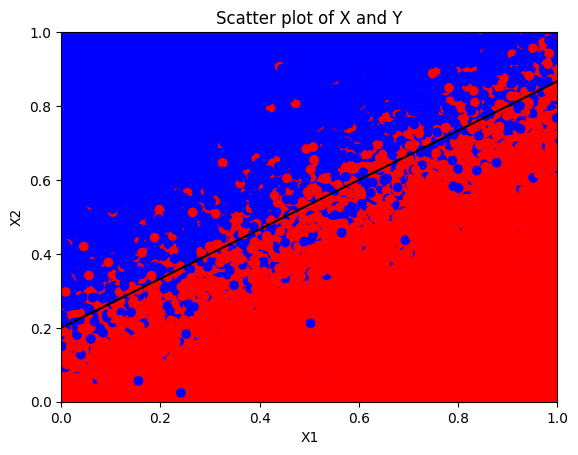

In [20]:
def f(x1, x2):
    return -10 * x1 + 15 * x2 - 3

def eta(x):
    return 1 / (1 + np.exp(f(*x)))


def create_data(n_samples=10000, d=2):
    X = np.random.uniform(0, 1, (n_samples, d))
    probabilities = eta(X.T)
    Y = np.random.binomial(1, probabilities)
    return X, Y

data2 = create_data(n_samples=100000,d=2)
X1 = data2[0]
Y1 = data2[1]

plt.scatter(X1[:, 0], X1[:, 1], c=Y1, cmap='bwr', alpha=1)
plt.xlabel('X1')
plt.ylabel('X2')
plt.xlim(0,1)
plt.title('Scatter plot of X and Y')


xx, yy = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
grid = np.c_[xx.ravel(), yy.ravel()]


f_values = f(grid[:, 0], grid[:, 1])
f_values = f_values.reshape(xx.shape)
plt.contour(xx, yy, f_values, levels=[0], colors='black')

plt.show()


# Non-synthetic Dataset (Stroke Prediction)

## Analysis

In [51]:
df=pd.read_csv(r'healthcare-dataset-stroke-data.csv')

In [52]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [53]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [55]:
drop_list = ['bmi','id']
df.drop(drop_list, axis=1, inplace=True)

In [56]:
categorical_vars = ['gender','ever_married', 'work_type','Residence_type','smoking_status']
label_encoders = {col: LabelEncoder() for col in categorical_vars}


for col in categorical_vars:
    df[col] = label_encoders[col].fit_transform(df[col])



In [57]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
smoking_status       0
stroke               0
dtype: int64

In [58]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,1,1
1,0,61.0,0,0,1,3,0,202.21,2,1
2,1,80.0,0,1,1,2,0,105.92,2,1
3,0,49.0,0,0,1,2,1,171.23,3,1
4,0,79.0,1,0,1,3,0,174.12,2,1


In [59]:
# Split the data into training and testing sets
fraction_train = 0.8
fraction_test = 1.0 - fraction_train
df_train, df_test = train_test_split(df, train_size=fraction_train, test_size=fraction_test, random_state=42)


In [77]:

# Scale the data
scaler = MinMaxScaler()

# Separate features and target
y_train = df_train["stroke"]
X_train = df_train.drop(columns=["stroke"])
y_test = df_test["stroke"]
X_test = df_test.drop(columns=["stroke"])

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train=y_train.values
y_test=y_test.values

In [78]:
X_combined = np.vstack((X_train_scaled, X_test_scaled))
y_combined = np.hstack((y_train, y_test))

data_new = [X_combined, y_combined]


In [79]:
epsilon, A, eta, time_taken = active_learning_with_rejection(data_new, X_train_scaled, y_train, beta=1, N1=1000, d=2, c=2, M=100)
eta_values, labels = label_points(X_test_scaled, A, eta)
accuracy_al = accuracy_score(y_test, labels)
print(accuracy_al)
    

0.9393346379647749


# Algorithm

## Active Learning 

### Algo with Logistic Regression

In [3]:
def score_function(X, eta):
    probs = eta.predict_proba(X)[:, 1]
    scores = np.maximum(probs, 1 - probs)
    return scores


def find_threshold(Ak, eta, p):
    
    
    scores = score_function(Ak, eta)

    threshold = np.quantile(scores, p)
    
    return threshold

def active_learning_with_rejection_lr(data, X_train, Y_train, beta=1, N1=500, d=2, c=1.5, M=100):
    N = [int(np.sqrt(N1))]
    A = [data[0]]
    epsilon = [1]
    eta = []
    lambda_ = []
    D = [[]]

    B = N[0]
    L = [data[1]]
    k = 1
    time_taken=[]

    # Ensure both classes are present in the initial sample
    while True:
        indices = np.random.choice(len(X_train), size=N[0], replace=False)
        X0, Y0 = X_train[indices], Y_train[indices]
        if len(np.unique(Y0)) == 2:
            break

    eta_0 = LogisticRegression()
    eta_0.fit(X0, Y0)
    eta.append(eta_0)
    D[0] = list(zip(X0, Y0))

    delta = 0.46
    i = 1
    N.append(int(c * N[i - 1]))
    epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
    N_k = N[1]
    e_k = epsilon[1]
    lambda_.append(1)

    while B + np.floor(N_k * e_k) <= N1:
        t1 = time.time()

        indices1 = np.random.choice(len(A[i - 1]), size=M, replace=False)
        D_U = [A[i - 1][j] for j in indices1]
        lambda_.append(find_threshold(D_U, eta[i - 1], e_k))
        t2 = time.time()
        scores = score_function(np.array(A[i - 1]), eta[i - 1])
        mask = scores <= lambda_[i]
        A.append(np.array(A[i - 1])[mask].tolist())
        L.append(np.array(L[i - 1])[mask].tolist())

        D_U_set = set(map(tuple, D_U))
        A_next_filtered = [point for point in A[i] if tuple(point) not in D_U_set]
        L_next_filtered = [L[i][j] for j, point in enumerate(A[i]) if tuple(point) not in D_U_set]

        # Ensure both classes are present in the sample
        while True:
            sample_size = min(len(L_next_filtered), int(np.floor(N_k * e_k)))
            indices = np.random.choice(len(L_next_filtered), size=sample_size, replace=False)
            d_points = [(A_next_filtered[h], L_next_filtered[h]) for h in indices]
            if len(np.unique([label for _, label in d_points])) == 2:
                break

        D.append(d_points)

        t3 = time.time()

        X_i = [pair[0] for pair in D[i]]
        Y_i = [pair[1] for pair in D[i]]
        t4 = time.time()
        eta_i = LogisticRegression()
        eta_i.fit(X_i, Y_i)
        eta.append(eta_i)
        t5 = time.time()
        B += np.floor(N_k * e_k)
        i += 1
        N.append(int(c * N[i - 1]))
        epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
        N_k = N[i]
        e_k = epsilon[i]
        t6 = time.time()
        time_taken.append([t2-t1, t3-t2, t4-t3, t5-t4, t6-t5, t6-t1])

    return epsilon, A, eta, time_taken

def label_points(X_test, A, eta):
    A_arrays = [np.array(sublist) for sublist in A]
    eta_values = np.zeros(len(X_test))
    labels = np.zeros(len(X_test), dtype=int)

    for j in range(len(eta) - 1):
        mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
        
        if not np.any(mask_j):
            continue

        eta_values[mask_j] += eta[j].predict_proba(X_test[mask_j])[:, 1]

    mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
    
    if np.any(mask_last):
        eta_values[mask_last] += eta[-1].predict_proba(X_test[mask_last])[:, 1]

    labels = (eta_values >= 0.5).astype(int)
    return eta_values, labels


### Algo with SVC

In [4]:
def active_learning_with_rejection_svc(data, X_train, Y_train, beta=1, N1=500, d=2, c=1.5, M=100):
    N = [int(np.sqrt(N1))]
    A = [data[0]]
    epsilon = [1]
    eta = []
    lambda_ = []
    D = [[]]

    B = N[0]
    L = [data[1]]
    k = 1
    time_taken=[]

    # Ensure both classes are present in the initial sample
    while True:
        indices = np.random.choice(len(X_train), size=N[0], replace=False)
        X0, Y0 = X_train[indices], Y_train[indices]
        if len(np.unique(Y0)) == 2:
            break

    eta_0 = SVC(probability=True, random_state=42)
    eta_0.fit(X0, Y0)
    eta.append(eta_0)
    D[0] = list(zip(X0, Y0))

    delta = 0.46
    i = 1
    N.append(int(c * N[i - 1]))
    epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
    N_k = N[1]
    e_k = epsilon[1]
    lambda_.append(1)

    while B + np.floor(N_k * e_k) <= N1:
        t1 = time.time()

        indices1 = np.random.choice(len(A[i - 1]), size=M, replace=False)
        D_U = [A[i - 1][j] for j in indices1]
        lambda_.append(find_threshold(D_U, eta[i - 1], e_k))
        t2 = time.time()
        scores = score_function(np.array(A[i - 1]), eta[i - 1])
        mask = scores <= lambda_[i]
        A.append(np.array(A[i - 1])[mask].tolist())
        L.append(np.array(L[i - 1])[mask].tolist())

        D_U_set = set(map(tuple, D_U))
        A_next_filtered = [point for point in A[i] if tuple(point) not in D_U_set]
        L_next_filtered = [L[i][j] for j, point in enumerate(A[i]) if tuple(point) not in D_U_set]

        # Ensure both classes are present in the sample
        while True:
            sample_size = min(len(L_next_filtered), int(np.floor(N_k * e_k)))
            indices = np.random.choice(len(L_next_filtered), size=sample_size, replace=False)
            d_points = [(A_next_filtered[h], L_next_filtered[h]) for h in indices]
            if len(np.unique([label for _, label in d_points])) == 2:
                break

        D.append(d_points)

        t3 = time.time()

        X_i = [pair[0] for pair in D[i]]
        Y_i = [pair[1] for pair in D[i]]
        t4 = time.time()
        eta_i = SVC(probability=True, random_state=42)
        eta_i.fit(X_i, Y_i)
        eta.append(eta_i)
        t5 = time.time()
        B += np.floor(N_k * e_k)
        i += 1
        N.append(int(c * N[i - 1]))
        epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
        N_k = N[i]
        e_k = epsilon[i]
        t6 = time.time()
        time_taken.append([t2-t1, t3-t2, t4-t3, t5-t4, t6-t5, t6-t1])

    return epsilon, A, eta, time_taken



### Algo with Decision Tree

In [5]:
def active_learning_with_rejection_dt(data, X_train, Y_train, beta=1, N1=500, d=2, c=1.5, M=100):
    N = [int(np.sqrt(N1))]
    A = [data[0]]
    epsilon = [1]
    eta = []
    lambda_ = []
    D = [[]]

    B = N[0]
    L = [data[1]]
    k = 1
    time_taken=[]

    # Ensure both classes are present in the initial sample
    while True:
        indices = np.random.choice(len(X_train), size=N[0], replace=False)
        X0, Y0 = X_train[indices], Y_train[indices]
        if len(np.unique(Y0)) == 2:
            break

    eta_0 =  DecisionTreeClassifier(random_state=42)
    eta_0.fit(X0, Y0)
    eta.append(eta_0)
    D[0] = list(zip(X0, Y0))

    delta = 0.46
    i = 1
    N.append(int(c * N[i - 1]))
    epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
    N_k = N[1]
    e_k = epsilon[1]
    lambda_.append(1)

    while B + np.floor(N_k * e_k) <= N1:
        t1 = time.time()

        indices1 = np.random.choice(len(A[i - 1]), size=M, replace=False)
        D_U = [A[i - 1][j] for j in indices1]
        lambda_.append(find_threshold(D_U, eta[i - 1], e_k))
        t2 = time.time()
        scores = score_function(np.array(A[i - 1]), eta[i - 1])
        mask = scores <= lambda_[i]
        A.append(np.array(A[i - 1])[mask].tolist())
        L.append(np.array(L[i - 1])[mask].tolist())

        D_U_set = set(map(tuple, D_U))
        A_next_filtered = [point for point in A[i] if tuple(point) not in D_U_set]
        L_next_filtered = [L[i][j] for j, point in enumerate(A[i]) if tuple(point) not in D_U_set]

        # Ensure both classes are present in the sample
        while True:
            sample_size = min(len(L_next_filtered), int(np.floor(N_k * e_k)))
            indices = np.random.choice(len(L_next_filtered), size=sample_size, replace=False)
            d_points = [(A_next_filtered[h], L_next_filtered[h]) for h in indices]
            if len(np.unique([label for _, label in d_points])) == 2:
                break

        D.append(d_points)

        t3 = time.time()

        X_i = [pair[0] for pair in D[i]]
        Y_i = [pair[1] for pair in D[i]]
        t4 = time.time()
        eta_i = DecisionTreeClassifier(random_state=42)
        eta_i.fit(X_i, Y_i)
        eta.append(eta_i)
        t5 = time.time()
        B += np.floor(N_k * e_k)
        i += 1
        N.append(int(c * N[i - 1]))
        epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
        N_k = N[i]
        e_k = epsilon[i]
        t6 = time.time()
        time_taken.append([t2-t1, t3-t2, t4-t3, t5-t4, t6-t5, t6-t1])

    return epsilon, A, eta, time_taken



## QBC

In [6]:
def vote_entropy(committee, X):
   
    committee_votes = np.array([clf.predict(X) for clf in committee])
    bincounts = np.apply_along_axis(np.bincount, 0, committee_votes, minlength=2)
    probabilities = bincounts / len(committee)
    vote_entropy = -np.sum(probabilities * np.log(probabilities + 1e-10), axis=0)
    return vote_entropy

def query_by_committee_sampling(committee, X, n_instances=10):
    entropy = vote_entropy(committee, X)
    query_indices = np.argsort(entropy)[-n_instances:]
    return query_indices


def fit_classifier(clf, X, y):
    return clf.fit(X, y)



def active_learning_with_rejection_QBC(data, X_train, Y_train, beta=1, N1=200, d=2, c=1.1, M=100):
    N = [int(np.sqrt(N1))]
    A = [data[0]]
    epsilon = [1]
    eta = []
    lambda_ = []
    D = [[]]

    B = N[0]
    L = [data[1]]
    k = 1
    time_taken=[]

    
    
    classifier_types = [
        RandomForestClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42),
        SVC(probability=True, random_state=42),
        LogisticRegression(random_state=42),
        DecisionTreeClassifier(random_state=42)
    ]
    
    while True:
        indices = np.random.choice(len(X_train), size=N[0], replace=False)
        X0, Y0 = X_train[indices], Y_train[indices]
        if len(np.unique(Y0)) == 2:
            break
    committee = Parallel(n_jobs=-1)(
    delayed(fit_classifier)(clf, X0, Y0) for clf in classifier_types)

    eta.append(committee)

    D[0] = list(zip(X0, Y0))

    delta = 0.46
    i = 1
    N.append(int(c * N[i - 1]))
    epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
    N_k = N[1]
    e_k = epsilon[1]
    lambda_.append(1)

    while B + np.floor(N_k * e_k) <= N1:
        t1 = time.time()

        indices1 = query_by_committee_sampling(eta[i - 1], A[i - 1], M)
        D_U = [A[i - 1][j] for j in indices1]
        t=[]
        for k in range(5):
            t.append(find_threshold(D_U, eta[i - 1][k], e_k))

        
        lambda_.append(np.mean(t))
        t2 = time.time()
        scores = score_function(np.array(A[i - 1]), eta[i - 1][0])
        mask = scores <= lambda_[i]
        A.append(np.array(A[i - 1])[mask].tolist())
        L.append(np.array(L[i - 1])[mask].tolist())

        D_U_set = set(map(tuple, D_U))
        A_next_filtered = [point for point in A[i] if tuple(point) not in D_U_set]
        L_next_filtered = [L[i][j] for j, point in enumerate(A[i]) if tuple(point) not in D_U_set]

        # Ensure both classes are present in the sample
        while True:
            sample_size = min(len(L_next_filtered), int(np.floor(N_k * e_k)))
            indices = np.random.choice(len(L_next_filtered), size=sample_size, replace=False)
            d_points = [(A_next_filtered[h], L_next_filtered[h]) for h in indices]
            if len(np.unique([label for _, label in d_points])) == 2:
                break

        D.append(d_points)

        t3 = time.time()

        X_i = [pair[0] for pair in D[i]]
        Y_i = [pair[1] for pair in D[i]]
        t4 = time.time()
        
        classifier_types = [
        RandomForestClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42),
        SVC(probability=True, random_state=42),
        LogisticRegression(random_state=42),
        DecisionTreeClassifier(random_state=42)]
    

        new_committee = Parallel(n_jobs=-1)(
        delayed(fit_classifier)(clf, X_i, Y_i) for clf in classifier_types)

        eta.append(new_committee)

        t5 = time.time()
        B += np.floor(N_k * e_k)
        i += 1
        N.append(int(c * N[i - 1]))
        epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
        N_k = N[i]
        e_k = epsilon[i]
        t6 = time.time()
        time_taken.append([t2-t1, t3-t2, t4-t3, t5-t4, t6-t5, t6-t1])

    return epsilon, A, eta, time_taken


def label_points_QBC(X_test, A, eta):
    A_arrays = [np.array(sublist) for sublist in A]
    eta_values = np.zeros(len(X_test))
    labels = np.zeros(len(X_test), dtype=int)
    
    for j in range(len(eta) - 1):
        mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
        if not np.any(mask_j):
            continue
        eta_values[mask_j] += np.mean([clf.predict_proba(X_test[mask_j])[:, 1] for clf in eta[j]], axis=0)
    
    mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
    if np.any(mask_last):
        eta_values[mask_last] += np.mean([clf.predict_proba(X_test[mask_last])[:, 1] for clf in eta[-1]], axis=0)
    labels = (eta_values >= 0.5).astype(int)
    
    return eta_values, labels


In [110]:
def label_points_dt(X_test, A, eta):
    A_arrays = [np.array(sublist) for sublist in A]
    eta_values = np.zeros(len(X_test))
    labels = np.zeros(len(X_test), dtype=int)
    eta_new=[e[4] for e in eta]
    for j in range(len(eta_new) - 1):
        mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
        
        if not np.any(mask_j):
            continue

        eta_values[mask_j] += eta_new[j].predict_proba(X_test[mask_j])[:, 1]

    mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
    
    if np.any(mask_last):
        eta_values[mask_last] += eta_new[-1].predict_proba(X_test[mask_last])[:, 1]

    labels = (eta_values >= 0.5).astype(int)
    return eta_values, labels


## Uncertainity Sampling

### Logistic Regression

In [7]:
def uncertainty_sampling(model, X, n_instances=10):
    #print(X.shape)
    
    probs = model.predict_proba(X)[:, 1]
    margins = np.abs(probs - 0.5)
    query_indices = np.argsort(margins)[-n_instances:]
    return query_indices

def active_learning_with_rejection_US_lr(data, X_train, Y_train, beta=1, N1=200, d=2, c=1.1, M=100):
    N = [int(np.sqrt(N1))]
    A = [data[0]]
    epsilon = [1]
    eta = []
    lambda_ = []
    D = [[]]

    B = N[0]
    L = [data[1]]
    k = 1
    time_taken=[]
    while True:
        indices = np.random.choice(len(X_train), size=N[0], replace=False)
        X0, Y0 = X_train[indices], Y_train[indices]
        if len(np.unique(Y0)) == 2:
            break
    
    eta_0 = LogisticRegression()
    eta_0.fit(X0, Y0)
    eta.append(eta_0)

    D[0] = list(zip(X0, Y0))

    delta = 0.46
    i = 1
    N.append(int(c * N[i - 1]))
    epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
    N_k = N[1]
    e_k = epsilon[1]
    lambda_.append(1)

    while B + np.floor(N_k * e_k) <= N1:

        t1 = time.time()

        D_U_indices = uncertainty_sampling(eta[i - 1], A[i - 1], M)
        D_U = [A[i - 1][j] for j in D_U_indices]
        lambda_.append(find_threshold(D_U, eta[i - 1], e_k))
        

        t2 = time.time()
        scores = score_function(np.array(A[i - 1]), eta[i - 1])
        mask = scores <= lambda_[i]
        A.append(np.array(A[i - 1])[mask].tolist())
        L.append(np.array(L[i - 1])[mask].tolist())

        
        D_U_set = set(map(tuple, D_U))
        
        A_next_filtered = [point for point in A[i] if tuple(point) not in D_U_set]
        L_next_filtered = [L[i][j] for j, point in enumerate(A[i]) if tuple(point) not in D_U_set]
        
        while True:
            sample_size = min(len(L_next_filtered), int(np.floor(N_k * e_k)))
            indices = np.random.choice(len(L_next_filtered), size=sample_size, replace=False)
            d_points = [(A_next_filtered[h], L_next_filtered[h]) for h in indices]
            if len(np.unique([label for _, label in d_points])) == 2:
                break






        
        t3 = time.time()
        #print(N_k, e_k, np.floor(N_k * e_k),len(L[i]))
        
        D.append(d_points)

        X_i = [pair[0] for pair in D[i]]
        Y_i = [pair[1] for pair in D[i]]
        t4 = time.time()
        eta_i = LogisticRegression()
        eta_i.fit(X_i, Y_i)
        eta.append(eta_i)

        t5 = time.time()
        B += np.floor(N_k * e_k)
        i += 1
        N.append(int(c * N[i - 1]))
        epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
        N_k = N[i]
        e_k = epsilon[i]

        t6 = time.time()
        time_taken.append([t2-t1, t3-t2, t4-t3, t5-t4, t6-t5, t6-t1])

    return epsilon, A, eta, time_taken


### SVC

In [8]:
def active_learning_with_rejection_US_svc(data, X_train, Y_train, beta=1, N1=200, d=2, c=1.1, M=100):
    N = [int(np.sqrt(N1))]
    A = [data[0]]
    epsilon = [1]
    eta = []
    lambda_ = []
    D = [[]]

    B = N[0]
    L = [data[1]]
    k = 1
    time_taken=[]
    while True:
        indices = np.random.choice(len(X_train), size=N[0], replace=False)
        X0, Y0 = X_train[indices], Y_train[indices]
        if len(np.unique(Y0)) == 2:
            break
    
    eta_0 = SVC(probability=True, random_state=42)
    eta_0.fit(X0, Y0)
    eta.append(eta_0)

    D[0] = list(zip(X0, Y0))

    delta = 0.46
    i = 1
    N.append(int(c * N[i - 1]))
    epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
    N_k = N[1]
    e_k = epsilon[1]
    lambda_.append(1)

    while B + np.floor(N_k * e_k) <= N1:

        t1 = time.time()

        D_U_indices = uncertainty_sampling(eta[i - 1], A[i - 1], M)
        D_U = [A[i - 1][j] for j in D_U_indices]
        lambda_.append(find_threshold(D_U, eta[i - 1], e_k))
        

        t2 = time.time()
        scores = score_function(np.array(A[i - 1]), eta[i - 1])
        mask = scores <= lambda_[i]
        A.append(np.array(A[i - 1])[mask].tolist())
        L.append(np.array(L[i - 1])[mask].tolist())

        
        D_U_set = set(map(tuple, D_U))
        
        A_next_filtered = [point for point in A[i] if tuple(point) not in D_U_set]
        L_next_filtered = [L[i][j] for j, point in enumerate(A[i]) if tuple(point) not in D_U_set]
        
        while True:
            sample_size = min(len(L_next_filtered), int(np.floor(N_k * e_k)))
            indices = np.random.choice(len(L_next_filtered), size=sample_size, replace=False)
            d_points = [(A_next_filtered[h], L_next_filtered[h]) for h in indices]
            if len(np.unique([label for _, label in d_points])) == 2:
                break






        
        t3 = time.time()
        #print(N_k, e_k, np.floor(N_k * e_k),len(L[i]))
        
        D.append(d_points)

        X_i = [pair[0] for pair in D[i]]
        Y_i = [pair[1] for pair in D[i]]
        t4 = time.time()
        eta_i = SVC(probability=True, random_state=42)
        eta_i.fit(X_i, Y_i)
        eta.append(eta_i)

        t5 = time.time()
        B += np.floor(N_k * e_k)
        i += 1
        N.append(int(c * N[i - 1]))
        epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
        N_k = N[i]
        e_k = epsilon[i]

        t6 = time.time()
        time_taken.append([t2-t1, t3-t2, t4-t3, t5-t4, t6-t5, t6-t1])

    return epsilon, A, eta, time_taken


### Decision Tree

In [9]:
def active_learning_with_rejection_US_dt(data, X_train, Y_train, beta=1, N1=200, d=2, c=1.1, M=100):
    N = [int(np.sqrt(N1))]
    A = [data[0]]
    epsilon = [1]
    eta = []
    lambda_ = []
    D = [[]]

    B = N[0]
    L = [data[1]]
    k = 1
    time_taken=[]
    while True:
        indices = np.random.choice(len(X_train), size=N[0], replace=False)
        X0, Y0 = X_train[indices], Y_train[indices]
        if len(np.unique(Y0)) == 2:
            break
    
    eta_0 =  DecisionTreeClassifier(random_state=42)
    eta_0.fit(X0, Y0)
    eta.append(eta_0)

    D[0] = list(zip(X0, Y0))

    delta = 0.46
    i = 1
    N.append(int(c * N[i - 1]))
    epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
    N_k = N[1]
    e_k = epsilon[1]
    lambda_.append(1)

    while B + np.floor(N_k * e_k) <= N1:

        t1 = time.time()

        D_U_indices = uncertainty_sampling(eta[i - 1], A[i - 1], M)
        D_U = [A[i - 1][j] for j in D_U_indices]
        lambda_.append(find_threshold(D_U, eta[i - 1], e_k))
        

        t2 = time.time()
        scores = score_function(np.array(A[i - 1]), eta[i - 1])
        mask = scores <= lambda_[i]
        A.append(np.array(A[i - 1])[mask].tolist())
        L.append(np.array(L[i - 1])[mask].tolist())

        
        D_U_set = set(map(tuple, D_U))
        
        A_next_filtered = [point for point in A[i] if tuple(point) not in D_U_set]
        L_next_filtered = [L[i][j] for j, point in enumerate(A[i]) if tuple(point) not in D_U_set]
        
        while True:
            sample_size = min(len(L_next_filtered), int(np.floor(N_k * e_k)))
            indices = np.random.choice(len(L_next_filtered), size=sample_size, replace=False)
            d_points = [(A_next_filtered[h], L_next_filtered[h]) for h in indices]
            if len(np.unique([label for _, label in d_points])) == 2:
                break






        
        t3 = time.time()
        #print(N_k, e_k, np.floor(N_k * e_k),len(L[i]))
        
        D.append(d_points)

        X_i = [pair[0] for pair in D[i]]
        Y_i = [pair[1] for pair in D[i]]
        t4 = time.time()
        eta_i =  DecisionTreeClassifier(random_state=42)
        eta_i.fit(X_i, Y_i)
        eta.append(eta_i)

        t5 = time.time()
        B += np.floor(N_k * e_k)
        i += 1
        N.append(int(c * N[i - 1]))
        epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
        N_k = N[i]
        e_k = epsilon[i]

        t6 = time.time()
        time_taken.append([t2-t1, t3-t2, t4-t3, t5-t4, t6-t5, t6-t1])

    return epsilon, A, eta, time_taken


# Implementation Of Algorithm 

## For Synthetic Dataset

In [23]:
def run_experiments_synthetic(data, num_experiments=10):
    
    mean_svc = []
    mean_lr = []
    mean_dt = []
    mean_al_svc = []
    mean_al_lr=[]
    mean_al_dt=[]
    mean_us_lr=[]
    mean_us_svc=[]
    mean_us_dt=[]
    mean_qbc=[]
    for _ in range(num_experiments):
        
        X_train, X_test, Y_train, Y_test = train_test_split(data[0], data[1], test_size=0.3, random_state=42)
        
        
        
        committee = [
            SVC(probability=True, random_state=42),
            LogisticRegression(random_state=42),
            DecisionTreeClassifier(random_state=42)
        ]
        
        
        for clf, accuracy_list in zip(committee, [mean_svc, mean_lr, mean_dt]):
            indices = np.random.choice(len(X_train), size=400, replace=False)
            X0=X_train[indices]
            Y0=Y_train[indices]
            clf.fit(X0,Y0)
            predictions = clf.predict(X_test)
            accuracy = accuracy_score(Y_test, predictions)
            accuracy_list.append(accuracy)
        
        
        epsilon1, A1, eta1, time_taken1 = active_learning_with_rejection_lr(data, X_train, Y_train, beta=1, N1=400, d=2, c=2, M=50)
        eta_values1, labels1 = label_points(X_test, A1, eta1)
        accuracy_al1 = accuracy_score(Y_test, labels1)
        mean_al_lr.append(accuracy_al1)


        epsilon2, A2, eta2, time_taken2 = active_learning_with_rejection_svc(data, X_train, Y_train, beta=1, N1=400, d=2, c=2, M=50)
        eta_values2, labels2 = label_points(X_test, A2, eta2)
        accuracy_al2 = accuracy_score(Y_test, labels2)
        mean_al_svc.append(accuracy_al2)

        epsilon3, A3, eta3, time_taken3 = active_learning_with_rejection_dt(data, X_train, Y_train, beta=1, N1=400, d=2, c=2, M=50)
        eta_values3, labels3 = label_points(X_test, A3, eta3)
        accuracy_al3 = accuracy_score(Y_test, labels3)
        mean_al_dt.append(accuracy_al3)

        epsilon11, A11, eta11, time_taken11 = active_learning_with_rejection_US_lr(data, X_train, Y_train, beta=1, N1=400, d=2, c=2, M=50)
        eta_values11, labels11 = label_points(X_test, A11, eta11)
        accuracy_al11 = accuracy_score(Y_test, labels11)
        mean_us_lr.append(accuracy_al11)


        epsilon22, A22, eta22, time_taken22 = active_learning_with_rejection_US_svc(data, X_train, Y_train, beta=1, N1=400, d=2, c=2, M=50)
        eta_values22, labels22 = label_points(X_test, A22, eta22)
        accuracy_al22 = accuracy_score(Y_test, labels22)
        mean_us_svc.append(accuracy_al22)

        epsilon33, A33, eta33, time_taken33 = active_learning_with_rejection_US_dt(data, X_train, Y_train, beta=1, N1=400, d=2, c=2, M=50)
        eta_values33, labels33 = label_points(X_test, A33, eta33)
        accuracy_al33 = accuracy_score(Y_test, labels33)
        mean_us_dt.append(accuracy_al33)


        epsilon, A, eta, time_taken = active_learning_with_rejection_QBC(data, X_train, Y_train, beta=1, N1=400, d=2, c=2, M=50)
        eta_values, labels = label_points_QBC(X_test, A, eta)
        accuracy_qbc = accuracy_score(Y_test, labels)
        mean_qbc.append(accuracy_qbc)
        
  
    mean_misclassification_error = {'lr':np.mean(mean_lr),'svc':np.mean(mean_svc),'dt':np.mean(mean_dt),'al_lr':np.mean(mean_al_lr),
                                    'al_dt':np.mean(mean_al_dt),'al_svc':np.mean(mean_al_svc),'us_lr':np.mean(mean_us_lr),'us_svc':np.mean(mean_us_svc),
                                   'us_dt':np.mean(mean_us_dt),'qbc':np.mean(mean_qbc)}
    std_me={'lr':np.std(mean_lr),'svc':np.std(mean_svc),'dt':np.std(mean_dt),'al_lr':np.std(mean_al_lr),'al_svc':np.std(mean_al_svc),
            'al_dt':np.std(mean_al_dt),'us_lr':np.std(mean_us_lr),'us_svc':np.std(mean_us_svc),'us_dt':np.std(mean_us_dt),
           'qbc':np.std(mean_qbc)}
    return mean_misclassification_error,std_me
    


In [24]:
data=[X,Y]
mean_misclassification_error,std_me = run_experiments_synthetic(data, num_experiments=20)
print(mean_misclassification_error,std_me)

{'lr': 0.9186500000000001, 'svc': 0.9184833333333332, 'dt': 0.8739666666666667, 'al_lr': 0.9186166666666666, 'al_dt': 0.8734, 'al_svc': 0.9165333333333333, 'us_lr': 0.9164833333333334, 'us_svc': 0.9169333333333333, 'us_dt': 0.8780999999999999, 'qbc': 0.9157666666666667} {'lr': 0.0027638037396152146, 'svc': 0.002362849033593887, 'dt': 0.011128491961327628, 'al_lr': 0.0026146489035602603, 'al_svc': 0.0043797513881751555, 'al_dt': 0.02226621756034115, 'us_lr': 0.0018870170463812295, 'us_svc': 0.003431229128655402, 'us_dt': 0.020261101209515308, 'qbc': 0.0046465040621955795}


In [25]:
mean_misclassification_error1,std_me1 = run_experiments_synthetic(data2, num_experiments=20)
print(mean_misclassification_error,std_me)

{'lr': 0.9186500000000001, 'svc': 0.9184833333333332, 'dt': 0.8739666666666667, 'al_lr': 0.9186166666666666, 'al_dt': 0.8734, 'al_svc': 0.9165333333333333, 'us_lr': 0.9164833333333334, 'us_svc': 0.9169333333333333, 'us_dt': 0.8780999999999999, 'qbc': 0.9157666666666667} {'lr': 0.0027638037396152146, 'svc': 0.002362849033593887, 'dt': 0.011128491961327628, 'al_lr': 0.0026146489035602603, 'al_svc': 0.0043797513881751555, 'al_dt': 0.02226621756034115, 'us_lr': 0.0018870170463812295, 'us_svc': 0.003431229128655402, 'us_dt': 0.020261101209515308, 'qbc': 0.0046465040621955795}


In [26]:
print(mean_misclassification_error1,std_me1)

{'lr': 0.9049566666666669, 'svc': 0.90302, 'dt': 0.8646783333333333, 'al_lr': 0.8861533333333333, 'al_dt': 0.858165, 'al_svc': 0.8991816666666667, 'us_lr': 0.8961366666666668, 'us_svc': 0.8998666666666667, 'us_dt': 0.860985, 'qbc': 0.8870849999999999} {'lr': 0.0020092591227171826, 'svc': 0.0030241693074297225, 'dt': 0.009081013618166935, 'al_lr': 0.0241090794330914, 'al_svc': 0.00508658884824704, 'al_dt': 0.017876466451113255, 'us_lr': 0.01053417138016402, 'us_svc': 0.005612189115369036, 'us_dt': 0.016362900024819018, 'qbc': 0.0077914231691007555}


## For Non-Synthetic Dataset

In [42]:
def run_experiments_non_synthetic(num_experiments=10):
    mean_svc = []
    mean_lr = []
    mean_dt = []
    mean_al_svc = []
    mean_al_lr=[]
    mean_al_dt=[]
    mean_us_lr=[]
    mean_us_svc=[]
    mean_us_dt=[]
    mean_qbc_lr=[]
    mean_qbc_svc=[]
    mean_qbc_dt=[]
    mean_qbc=[]

    for _ in range(num_experiments):
        df = pd.read_csv(r'healthcare-dataset-stroke-data.csv')
        drop_list = ['bmi', 'id']
        df.drop(drop_list, axis=1, inplace=True)
        categorical_vars = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
        label_encoders = {col: LabelEncoder() for col in categorical_vars}
        
        for col in categorical_vars:
            df[col] = label_encoders[col].fit_transform(df[col])

        fraction_train = 0.7
        fraction_test = 0.3
        df_train, df_test = train_test_split(df, train_size=fraction_train, test_size=fraction_test, stratify=df['stroke'], random_state=42)

        # Scale the data
        scaler = MinMaxScaler()

        # Separate features and target
        y_train = df_train["stroke"]
        X_train = df_train.drop(columns=["stroke"])
        y_test = df_test["stroke"]
        X_test = df_test.drop(columns=["stroke"])

        # Fit the scaler on the training data and transform both training and testing data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        y_train = y_train.values
        y_test = y_test.values
        X_combined = np.vstack((X_train_scaled, X_test_scaled))
        y_combined = np.hstack((y_train, y_test))

        data_new = [X_combined, y_combined]

        
      
        committee = [
            SVC(probability=True, random_state=42),
            LogisticRegression(random_state=42),
            DecisionTreeClassifier(random_state=42)
        ]
        
        
        for clf, accuracy_list in zip(committee, [mean_svc, mean_lr, mean_dt]):
            indices = np.random.choice(len(X_train_scaled), size=500, replace=False)
            X0=X_train_scaled[indices]
            Y0=y_train[indices]
            clf.fit(X0,Y0)
            predictions = clf.predict(X_test_scaled)
            accuracy = accuracy_score(y_test, predictions)
            accuracy_list.append(accuracy)
        

        epsilon1, A1, eta1, time_taken1 = active_learning_with_rejection_lr(data_new, X_train_scaled, y_train, beta=1, N1=500, d=9, c=2, M=100)
        eta_values1, labels1 = label_points(X_test_scaled, A1, eta1)
        accuracy_al1 = accuracy_score(y_test, labels1)
        mean_al_lr.append(accuracy_al1)
        


        epsilon2, A2, eta2, time_taken2 = active_learning_with_rejection_svc(data_new, X_train_scaled, y_train, beta=1, N1=500, d=9, c=2, M=100)
        eta_values2, labels2 = label_points(X_test_scaled, A2, eta2)
        accuracy_al2 = accuracy_score(y_test, labels2)
        mean_al_svc.append(accuracy_al2)

        epsilon3, A3, eta3, time_taken3 = active_learning_with_rejection_dt(data_new, X_train_scaled, y_train, beta=1, N1=500, d=9, c=2, M=100)
        eta_values3, labels3 = label_points(X_test_scaled, A3, eta3)
        accuracy_al3 = accuracy_score(y_test, labels3)
        mean_al_dt.append(accuracy_al3)

        epsilon11, A11, eta11, time_taken11 = active_learning_with_rejection_US_lr(data_new,X_train_scaled, y_train, beta=1, N1=500, d=9, c=2, M=100)
        eta_values11, labels11 = label_points(X_test, A11, eta11)
        accuracy_al11 = accuracy_score(y_test, labels11)
        mean_us_lr.append(accuracy_al11)


        epsilon22, A22, eta22, time_taken22 = active_learning_with_rejection_US_svc(data_new, X_train_scaled, y_train, beta=1, N1=500, d=9, c=2, M=100)
        eta_values22, labels22 = label_points(X_test, A22, eta22)
        accuracy_al22 = accuracy_score(y_test, labels22)
        mean_us_svc.append(accuracy_al22)

        epsilon33, A33, eta33, time_taken33 = active_learning_with_rejection_US_dt(data_new,X_train_scaled, y_train, beta=1, N1=500, d=9, c=2, M=100)
        eta_values33, labels33 = label_points(X_test, A33, eta33)
        accuracy_al33 = accuracy_score(y_test, labels33)
        mean_us_dt.append(accuracy_al33)


        epsilon, A, eta, time_taken = active_learning_with_rejection_QBC(data_new, X_train_scaled, y_train, beta=1, N1=500, d=9, c=2, M=100)
        eta_values, labels = label_points_QBC(X_test, A, eta)
        accuracy_qbc = accuracy_score(y_test, labels)
        mean_qbc.append(accuracy_qbc)
       
        
        epsilon1, A1, eta1, time_taken1,eta_values1, labels1=None,None,None,None,None,None
        epsilon2, A2, eta2, time_taken2,eta_values2, labels2=None,None,None,None,None,None
        psilon3, A3, eta3, time_taken3 ,eta_values3, labels3=None,None,None,None,None,None
    

    
    mean_misclassification_error = {'lr':np.mean(mean_lr),'svc':np.mean(mean_svc),'dt':np.mean(mean_dt),'al_lr':np.mean(mean_al_lr),
                                    'al_dt':np.mean(mean_al_dt),'al_svc':np.mean(mean_al_svc),'us_lr':np.mean(mean_us_lr),'us_svc':np.mean(mean_us_svc),
                                   'us_dt':np.mean(mean_us_dt),'qbc':np.mean(mean_qbc)}
    std_me={'lr':np.std(mean_lr),'svc':np.std(mean_svc),'dt':np.std(mean_dt),'al_lr':np.std(mean_al_lr),'al_svc':np.std(mean_al_svc),
            'al_dt':np.std(mean_al_dt),'us_lr':np.std(mean_us_lr),'us_svc':np.std(mean_us_svc),'us_dt':np.std(mean_us_dt),
           'qbc':np.std(mean_qbc)}
    return mean_misclassification_error,std_me
    


In [43]:
mean_misclassification_error2,std_me2 = run_experiments_non_synthetic(num_experiments=20)
print(mean_misclassification_error2,std_me2)

{'lr': 0.9510763209393348, 'svc': 0.9510763209393348, 'dt': 0.9056099151989564, 'al_lr': 0.9507501630789303, 'al_dt': 0.9151989562948465, 'al_svc': 0.9509458577951729, 'us_lr': 0.9510763209393348, 'us_svc': 0.9510763209393348, 'us_dt': 0.9510763209393348, 'qbc': 0.9510763209393348} {'lr': 0.0003572880349022711, 'svc': 2.220446049250313e-16, 'dt': 0.009662423173997039, 'al_lr': 0.0012799358689072663, 'al_svc': 0.0007881960843831947, 'al_dt': 0.014131332731170003, 'us_lr': 2.220446049250313e-16, 'us_svc': 2.220446049250313e-16, 'us_dt': 2.220446049250313e-16, 'qbc': 2.220446049250313e-16}


In [44]:
mean_misclassification_error3,std_me3 = run_experiments_non_synthetic(num_experiments=20)
print(mean_misclassification_error3,std_me3)

{'lr': 0.9510110893672538, 'svc': 0.9510763209393348, 'dt': 0.9110893672537509, 'al_lr': 0.9508153946510112, 'al_dt': 0.9079908675799085, 'al_svc': 0.9491519895629488, 'us_lr': 0.9510763209393348, 'us_svc': 0.9510763209393348, 'us_dt': 0.9510763209393348, 'qbc': 0.9510763209393348} {'lr': 0.0005797908948020618, 'svc': 2.220446049250313e-16, 'dt': 0.009664624833554404, 'al_lr': 0.0007263880447266766, 'al_svc': 0.003932738934443039, 'al_dt': 0.01574700823762378, 'us_lr': 2.220446049250313e-16, 'us_svc': 2.220446049250313e-16, 'us_dt': 2.220446049250313e-16, 'qbc': 2.220446049250313e-16}


# Defining Class

## Active Learning

### Class for Logistic Regression

In [10]:
class ActiveLearningClassifier_lr(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_lr(
            data=data, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
    
            eta_values[mask_j] += self.eta[j].predict_proba(X_test[mask_j])[:, 1]
    
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        
        if np.any(mask_last):
            eta_values[mask_last] += self.eta[-1].predict_proba(X_test[mask_last])[:, 1]
    
        labels = (eta_values >= 0.5).astype(int)
        return labels


    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


In [11]:
class ActiveLearningClassifier_NS_lr(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_lr(
            data=data_new, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
    
            eta_values[mask_j] += self.eta[j].predict_proba(X_test[mask_j])[:, 1]
    
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        
        if np.any(mask_last):
            eta_values[mask_last] += self.eta[-1].predict_proba(X_test[mask_last])[:, 1]
    
        labels = (eta_values >= 0.5).astype(int)
        return labels


    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


### Class Of SVC

In [12]:
class ActiveLearningClassifier_SVC(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_svc(
            data=data, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
    
            eta_values[mask_j] += self.eta[j].predict_proba(X_test[mask_j])[:, 1]
    
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        
        if np.any(mask_last):
            eta_values[mask_last] += self.eta[-1].predict_proba(X_test[mask_last])[:, 1]
    
        labels = (eta_values >= 0.5).astype(int)
        return labels


    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


In [13]:
class ActiveLearningClassifier_NS_SVC(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_svc(
            data=data_new, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
    
            eta_values[mask_j] += self.eta[j].predict_proba(X_test[mask_j])[:, 1]
    
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        
        if np.any(mask_last):
            eta_values[mask_last] += self.eta[-1].predict_proba(X_test[mask_last])[:, 1]
    
        labels = (eta_values >= 0.5).astype(int)
        return labels


    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


### Class Of decision tree

In [14]:
class ActiveLearningClassifier_DT(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_dt(
            data=data, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
    
            eta_values[mask_j] += self.eta[j].predict_proba(X_test[mask_j])[:, 1]
    
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        
        if np.any(mask_last):
            eta_values[mask_last] += self.eta[-1].predict_proba(X_test[mask_last])[:, 1]
    
        labels = (eta_values >= 0.5).astype(int)
        return labels


    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


In [15]:
class ActiveLearningClassifier_NS_DT(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_dt(
            data=data_new, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
    
            eta_values[mask_j] += self.eta[j].predict_proba(X_test[mask_j])[:, 1]
    
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        
        if np.any(mask_last):
            eta_values[mask_last] += self.eta[-1].predict_proba(X_test[mask_last])[:, 1]
    
        labels = (eta_values >= 0.5).astype(int)
        return labels


    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


## QBC

In [16]:
class ActiveLearningClassifier_QBC(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_QBC(
            data=data, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
                
            eta_values[mask_j] += np.mean([clf.predict_proba(X_test[mask_j])[:, 1] for clf in self.eta[j]], axis=0)
        
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        if np.any(mask_last):
            eta_values[mask_last] += np.mean([clf.predict_proba(X_test[mask_last])[:, 1] for clf in self.eta[-1]], axis=0)
            
        labels = (eta_values >= 0.5).astype(int)
        
        return labels
    

    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


In [17]:
class ActiveLearningClassifier_NS_QBC(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_QBC(
            data=data_new, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
                
            eta_values[mask_j] += np.mean([clf.predict_proba(X_test[mask_j])[:, 1] for clf in self.eta[j]], axis=0)
        
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        if np.any(mask_last):
            eta_values[mask_last] += np.mean([clf.predict_proba(X_test[mask_last])[:, 1] for clf in self.eta[-1]], axis=0)
            
        labels = (eta_values >= 0.5).astype(int)
        
        return labels
        


    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


## Uncertainity Sampling

### Logistic Regression

In [18]:
class ActiveLearningClassifier_US_lr(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_US_lr(
            data=data, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
    
            eta_values[mask_j] += self.eta[j].predict_proba(X_test[mask_j])[:, 1]
    
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        
        if np.any(mask_last):
            eta_values[mask_last] += self.eta[-1].predict_proba(X_test[mask_last])[:, 1]
    
        labels = (eta_values >= 0.5).astype(int)
        return labels


    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


In [19]:
class ActiveLearningClassifier_US_NS_lr(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_US_lr(
            data=data_new, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
    
            eta_values[mask_j] += self.eta[j].predict_proba(X_test[mask_j])[:, 1]
    
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        
        if np.any(mask_last):
            eta_values[mask_last] += self.eta[-1].predict_proba(X_test[mask_last])[:, 1]
    
        labels = (eta_values >= 0.5).astype(int)
        return labels


    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


### SVC

In [20]:
class ActiveLearningClassifier_US_SVC(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_US_svc(
            data=data, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
    
            eta_values[mask_j] += self.eta[j].predict_proba(X_test[mask_j])[:, 1]
    
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        
        if np.any(mask_last):
            eta_values[mask_last] += self.eta[-1].predict_proba(X_test[mask_last])[:, 1]
    
        labels = (eta_values >= 0.5).astype(int)
        return labels


    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


In [21]:
class ActiveLearningClassifier_US_NS_SVC(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_US_svc(
            data=data_new, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
    
            eta_values[mask_j] += self.eta[j].predict_proba(X_test[mask_j])[:, 1]
    
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        
        if np.any(mask_last):
            eta_values[mask_last] += self.eta[-1].predict_proba(X_test[mask_last])[:, 1]
    
        labels = (eta_values >= 0.5).astype(int)
        return labels


    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


### Decision Tree

In [22]:
class ActiveLearningClassifier_US_DT(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_US_dt(
            data=data, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
    
            eta_values[mask_j] += self.eta[j].predict_proba(X_test[mask_j])[:, 1]
    
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        
        if np.any(mask_last):
            eta_values[mask_last] += self.eta[-1].predict_proba(X_test[mask_last])[:, 1]
    
        labels = (eta_values >= 0.5).astype(int)
        return labels


    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


In [23]:
class ActiveLearningClassifier_US_NS_DT(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection_US_dt(
            data=data_new, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))
        labels = np.zeros(len(X_test), dtype=int)
    
        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            
            if not np.any(mask_j):
                continue
    
            eta_values[mask_j] += self.eta[j].predict_proba(X_test[mask_j])[:, 1]
    
        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        
        if np.any(mask_last):
            eta_values[mask_last] += self.eta[-1].predict_proba(X_test[mask_last])[:, 1]
    
        labels = (eta_values >= 0.5).astype(int)
        return labels


    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


# Budget Vs N1

## For Synthetic Dataset


### Logistic Regression

In [35]:
evaluate_n1_qbc(200, X_train, Y_train, X_test, Y_test)

(200, 0.9283333333333333)

done
done
done
done


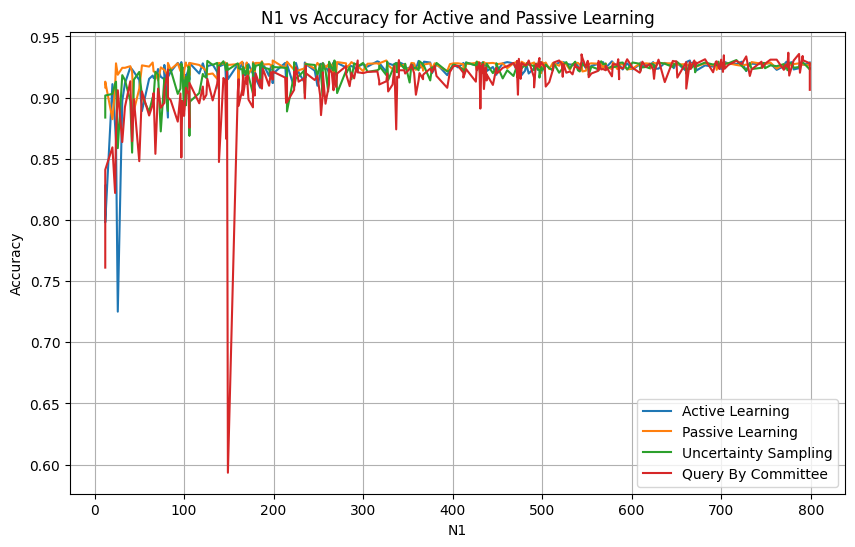

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

def evaluate_n1_active(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier_lr(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score

def evaluate_n1_passive(N1, X_train, y_train, X_test, y_test):
    indices = np.random.choice(len(X_train), size=N1, replace=False)
    X_train_sample = X_train[indices]
    Y_train_sample = y_train[indices]
    
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train_sample, Y_train_sample)
    predictions = clf.predict(X_test)
    score = accuracy_score(y_test, predictions)
    return N1, score
    
def evaluate_n1_us(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier_US_lr(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score


def evaluate_n1_qbc(N1, X_train, y_train, X_test, y_test):
    try:
        clf = ActiveLearningClassifier_QBC(N1=N1)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        return N1, score
    except Exception as e:
        print(f"Error in QBC evaluation for N1={N1}: {e}")
        return N1, None

    
random_sizes = np.random.randint(10, 800, 300)
sorted_sizes = np.sort(random_sizes)
n1_values = sorted_sizes.tolist()

# Evaluate active learning in parallel
results_active = Parallel(n_jobs=-1)(delayed(evaluate_n1_active)(N1, X_train, Y_train, X_test, Y_test) for N1 in n1_values)
print("done")
# Evaluate passive learning in parallel
results_passive = Parallel(n_jobs=-1)(delayed(evaluate_n1_passive)(N1, X_train, Y_train, X_test, Y_test) for N1 in n1_values)
print("done")
results_us=Parallel(n_jobs=-1)(delayed(evaluate_n1_us)(N1, X_train, Y_train, X_test, Y_test) for N1 in n1_values)
print("done")
results_qbc=Parallel(n_jobs=-1)(delayed(evaluate_n1_qbc)(N1, X_train, Y_train, X_test, Y_test) for N1 in n1_values)

print("done")
# Extract results
n1_values_active, active_accuracies = zip(*results_active)
n1_values_passive, passive_accuracies = zip(*results_passive)
n1_values_us, us_accuracies = zip(*results_us)
n1_values_qbc, qbc_accuracies = zip(*results_qbc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n1_values_active, active_accuracies, label='Active Learning')
plt.plot(n1_values_passive, passive_accuracies, label='Passive Learning')
plt.plot(n1_values_us, us_accuracies, label='Uncertainty Sampling')
plt.plot(n1_values_qbc, qbc_accuracies, label='Query By Committee')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('N1 vs Accuracy for Active and Passive Learning')
plt.legend()
plt.grid(True)
plt.show()

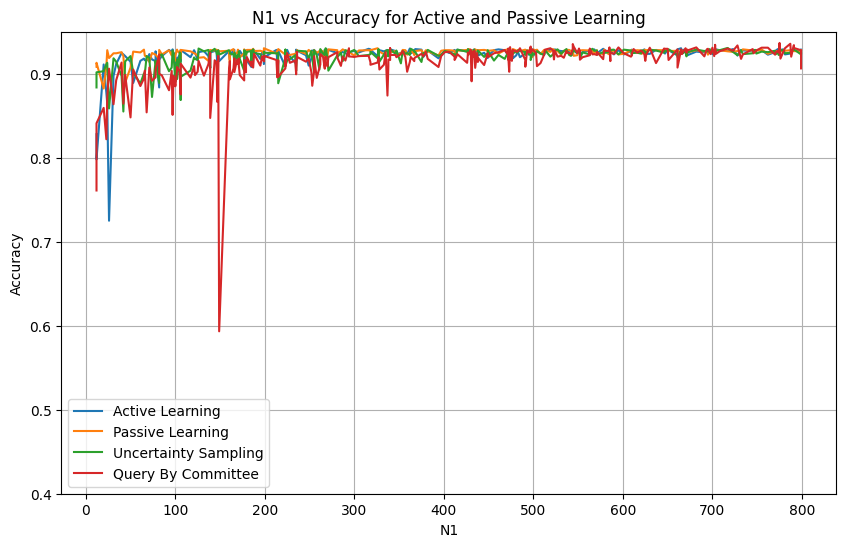

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(n1_values_active, active_accuracies, label='Active Learning')
plt.plot(n1_values_passive, passive_accuracies, label='Passive Learning')
plt.plot(n1_values_us, us_accuracies, label='Uncertainty Sampling')
plt.plot(n1_values_qbc, qbc_accuracies, label='Query By Committee')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('N1 vs Accuracy for Active and Passive Learning')
plt.legend()
plt.ylim(0.4,0.95)
plt.grid(True)
plt.show()

### SVC

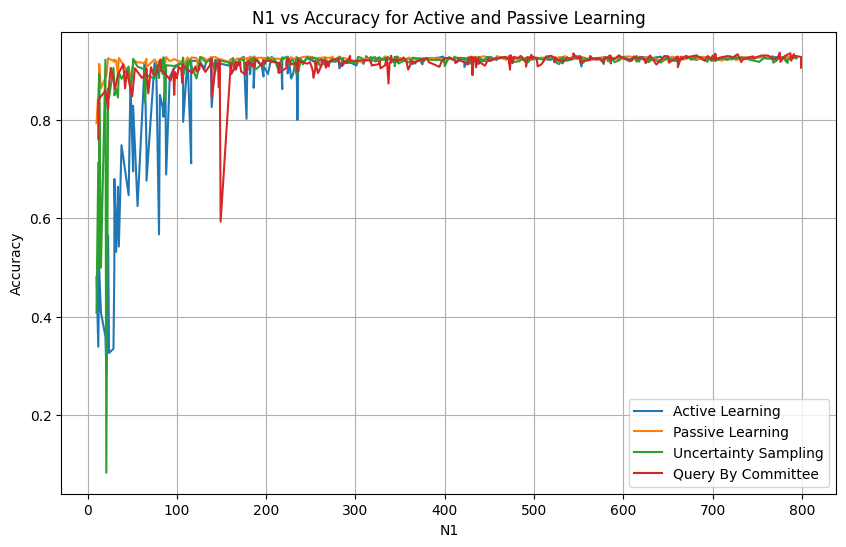

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

def evaluate_n1_active_svc(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier_SVC(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score

def evaluate_n1_passive_svc(N1, X_train, y_train, X_test, y_test):
    indices = np.random.choice(len(X_train), size=N1, replace=False)
    X_train_sample = X_train[indices]
    Y_train_sample = y_train[indices]
    
    clf = SVC(probability=True, random_state=42)
    clf.fit(X_train_sample, Y_train_sample)
    predictions = clf.predict(X_test)
    score = accuracy_score(y_test, predictions)
    return N1, score
    
def evaluate_n1_us_svc(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier_US_SVC(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score

def evaluate_n1_qbc(N1, X_train, y_train, X_test, y_test):
    try:
        clf = ActiveLearningClassifier_QBC(N1=N1)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        return N1, score
    except Exception as e:
        print(f"Error in QBC evaluation for N1={N1}: {e}")
        return N1, None


random_sizes = np.random.randint(10, 800, 300)
sorted_sizes = np.sort(random_sizes)
n1_values = sorted_sizes.tolist()

# Evaluate active learning in parallel
results_active_svc = Parallel(n_jobs=-1)(delayed(evaluate_n1_active_svc)(N1, X_train, Y_train, X_test, Y_test) for N1 in n1_values)

# Evaluate passive learning in parallel
results_passive_svc = Parallel(n_jobs=-1)(delayed(evaluate_n1_passive_svc)(N1, X_train, Y_train, X_test, Y_test) for N1 in n1_values)
results_us_svc=Parallel(n_jobs=-1)(delayed(evaluate_n1_us_svc)(N1, X_train, Y_train, X_test, Y_test) for N1 in n1_values)
#results_qbc=Parallel(n_jobs=-1)(delayed(evaluate_n1_qbc)(N1, X_train, Y_train, X_test, Y_test) for N1 in n1_values)

# Extract results
n1_values_active, active_accuracies = zip(*results_active_svc)
n1_values_passive, passive_accuracies = zip(*results_passive_svc)
n1_values_us, us_accuracies = zip(*results_us_svc)
n1_values_qbc, qbc_accuracies = zip(*results_qbc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n1_values_active, active_accuracies, label='Active Learning')
plt.plot(n1_values_passive, passive_accuracies, label='Passive Learning')
plt.plot(n1_values_us, us_accuracies, label='Uncertainty Sampling')
plt.plot(n1_values_qbc, qbc_accuracies, label='Query By Committee')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('N1 vs Accuracy for Active and Passive Learning')
plt.legend()
plt.grid(True)
plt.show()

### Decision Tree

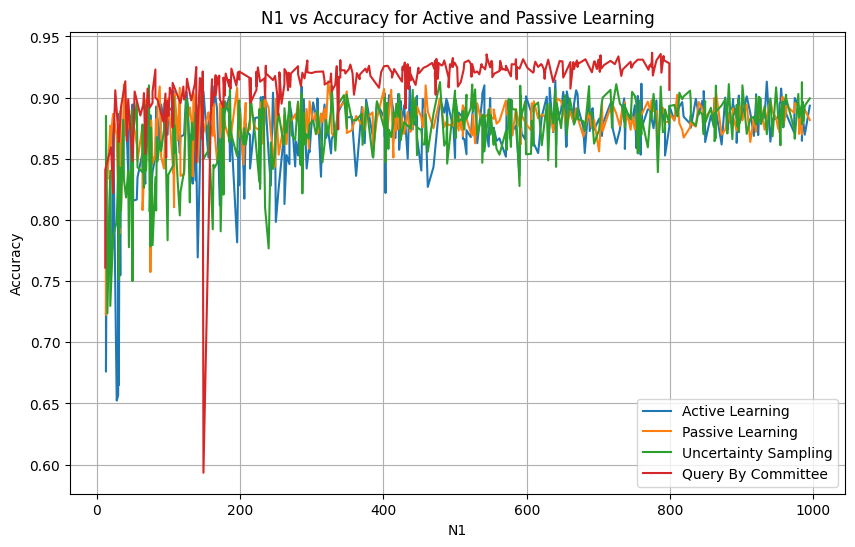

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

def evaluate_n1_active_dt(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier_DT(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score

def evaluate_n1_passive_dt(N1, X_train, y_train, X_test, y_test):
    indices = np.random.choice(len(X_train), size=N1, replace=False)
    X_train_sample = X_train[indices]
    Y_train_sample = y_train[indices]
    
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train_sample, Y_train_sample)
    predictions = clf.predict(X_test)
    score = accuracy_score(y_test, predictions)
    return N1, score
    
def evaluate_n1_us_dt(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier_US_DT(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score

def evaluate_n1_qbc(N1, X_train, y_train, X_test, y_test):
    try:
        clf = ActiveLearningClassifier_QBC(N1=N1)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        return N1, score
    except Exception as e:
        print(f"Error in QBC evaluation for N1={N1}: {e}")
        return N1, None
    
random_sizes = np.random.randint(10, 1000, 400)
sorted_sizes = np.sort(random_sizes)
n1_values = sorted_sizes.tolist()

# Evaluate active learning in parallel
results_active_dt = Parallel(n_jobs=-1)(delayed(evaluate_n1_active_dt)(N1, X_train, Y_train, X_test, Y_test) for N1 in n1_values)

# Evaluate passive learning in parallel
results_passive_dt = Parallel(n_jobs=-1)(delayed(evaluate_n1_passive_dt)(N1, X_train, Y_train, X_test, Y_test) for N1 in n1_values)
results_us_dt=Parallel(n_jobs=-1)(delayed(evaluate_n1_us_dt)(N1, X_train, Y_train, X_test, Y_test) for N1 in n1_values)
#results_qbc=Parallel(n_jobs=-1)(delayed(evaluate_n1_qbc)(N1, X_train, Y_train, X_test, Y_test) for N1 in n1_values)

# Extract results
n1_values_active, active_accuracies = zip(*results_active_dt)
n1_values_passive, passive_accuracies = zip(*results_passive_dt)
n1_values_us, us_accuracies = zip(*results_us_dt)
n1_values_qbc, qbc_accuracies = zip(*results_qbc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n1_values_active, active_accuracies, label='Active Learning')
plt.plot(n1_values_passive, passive_accuracies, label='Passive Learning')
plt.plot(n1_values_us, us_accuracies, label='Uncertainty Sampling')
plt.plot(n1_values_qbc, qbc_accuracies, label='Query By Committee')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('N1 vs Accuracy for Active and Passive Learning')
plt.legend()
plt.grid(True)
plt.show()

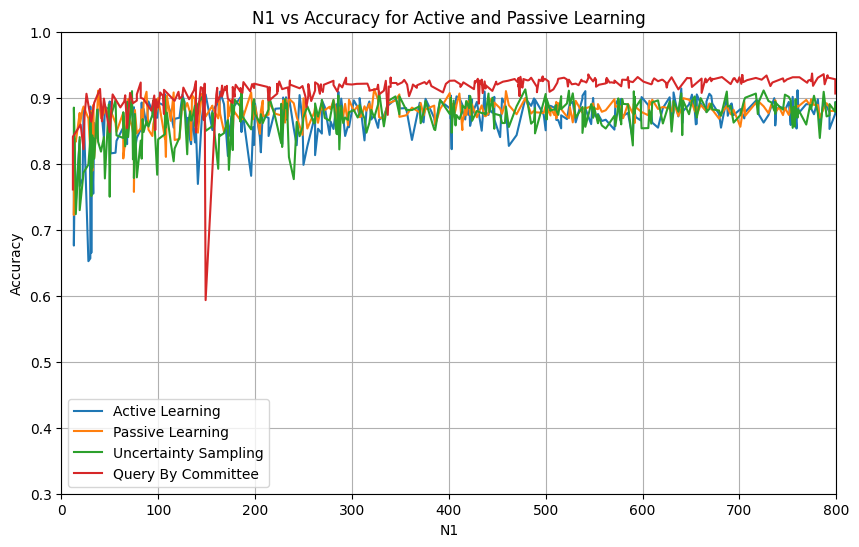

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(n1_values_active, active_accuracies, label='Active Learning')
plt.plot(n1_values_passive, passive_accuracies, label='Passive Learning')
plt.plot(n1_values_us, us_accuracies, label='Uncertainty Sampling')
plt.plot(n1_values_qbc, qbc_accuracies, label='Query By Committee')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('N1 vs Accuracy for Active and Passive Learning')
plt.legend()
plt.xlim(0,800)
plt.ylim(0.3,1)
plt.grid(True)
plt.show()

## Non-synthetic Dataset

In [24]:
df = pd.read_csv(r'healthcare-dataset-stroke-data.csv')
drop_list = ['bmi', 'id']
df.drop(drop_list, axis=1, inplace=True)
categorical_vars = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
label_encoders = {col: LabelEncoder() for col in categorical_vars}

for col in categorical_vars:
    df[col] = label_encoders[col].fit_transform(df[col])

fraction_train = 0.7
fraction_test = 0.3
df_train, df_test = train_test_split(df, train_size=fraction_train, test_size=fraction_test, stratify=df['stroke'], random_state=42)

# Scale the data
scaler = MinMaxScaler()

# Separate features and target
y_train = df_train["stroke"]
X_train = df_train.drop(columns=["stroke"])
y_test = df_test["stroke"]
X_test = df_test.drop(columns=["stroke"])

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = y_train.values
y_test = y_test.values
X_combined = np.vstack((X_train_scaled, X_test_scaled))
y_combined = np.hstack((y_train, y_test))

data_new = [X_combined, y_combined]

### Logistic regression

In [61]:
evaluate_n1_active(1000,X_train_scaled, y_train, X_test_scaled, y_test)

(1000, 0.9510763209393346)

done


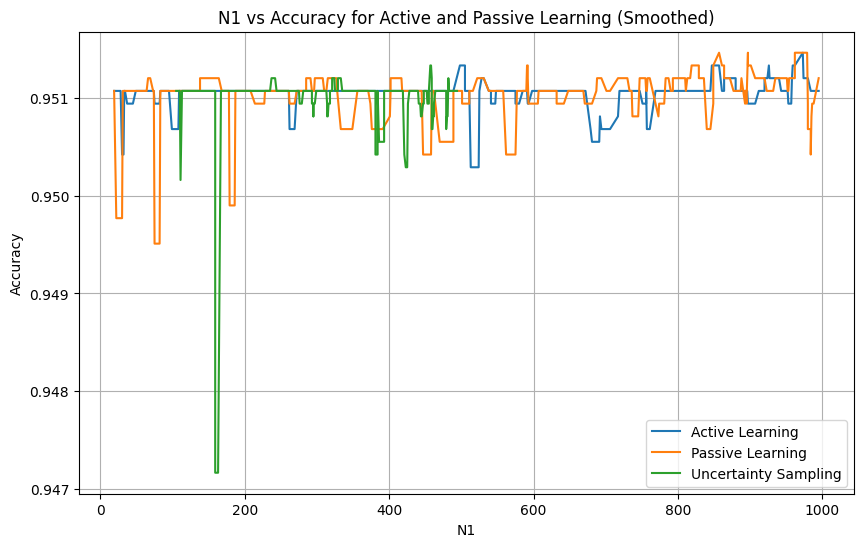

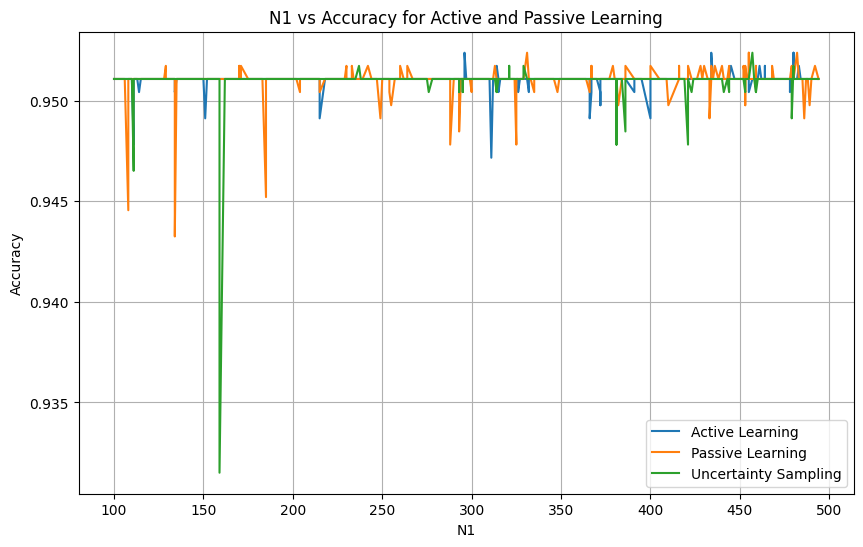

In [75]:
def evaluate_n1_active(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier_NS_lr(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score

def evaluate_n1_passive(N1, X_train, y_train, X_test, y_test):
    indices = np.random.choice(len(X_train), size=N1, replace=False)
    X_train_sample = X_train[indices]
    Y_train_sample = y_train[indices]
    
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train_sample, Y_train_sample)
    predictions = clf.predict(X_test)
    score = accuracy_score(y_test, predictions)
    return N1, score

def evaluate_n1_us(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier_US_NS_lr(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score

def evaluate_n1_qbc(N1, X_train, y_train, X_test, y_test):
    try:
        clf = ActiveLearningClassifier_NS_QBC(N1=N1)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        return N1, score
    except Exception as e:
        print(f"Error in QBC evaluation for N1={N1}: {e}")
        return N1, None

random_sizes = np.random.randint(100, 500, 400)
sorted_sizes = np.sort(random_sizes)
n1_values = sorted_sizes.tolist()

# Evaluate active learning in parallel
results_active_NS_LR = Parallel(n_jobs=-1)(delayed(evaluate_n1_active)(N1, X_train_scaled, y_train, X_test_scaled, y_test) for N1 in n1_values)

# Evaluate passive learning in parallel
results_passive_NS_LR = Parallel(n_jobs=-1)(delayed(evaluate_n1_passive)(N1, X_train_scaled, y_train, X_test_scaled, y_test) for N1 in n1_values)
results_ns_us=Parallel(n_jobs=-1)(delayed(evaluate_n1_us)(N1, X_train_scaled, y_train, X_test_scaled, y_test) for N1 in n1_values)
print("done")
#results_ns_qbc=Parallel(n_jobs=-1)(delayed(evaluate_n1_qbc)(N1,X_train_scaled, y_train, X_test_scaled, y_test) for N1 in n1_values)

#print("done")
# Extract results
n1_values_active_ns_lr, active_accuracies_ns_lr = zip(*results_active_NS_LR)
n1_values_passive_ns_lr, passive_accuracies_ns_lr = zip(*results_passive_NS_LR)
n1_values_us, us_accuracies = zip(*results_ns_us)
#n1_values_qbc, qbc_accuracies = zip(*results_ns_qbc)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average to smooth the accuracy curves
window_size = 5
active_accuracies_smooth = moving_average(active_accuracies_ns_lr, window_size)
passive_accuracies_smooth = moving_average(passive_accuracies_ns_lr, window_size)
us_accuracies_smooth = moving_average(us_accuracies, window_size)
qbc_accuracies_smooth = moving_average(qbc_accuracies, window_size)


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n1_values_active_ns_lr, active_accuracies_ns_lr, label='Active Learning')
plt.plot(n1_values_passive_ns_lr, passive_accuracies_ns_lr, label='Passive Learning')
plt.plot(n1_values_us, us_accuracies, label='Uncertainty Sampling')
#plt.plot(n1_values_qbc, qbc_accuracies, label='Query By Committee')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('N1 vs Accuracy for Active and Passive Learning')
plt.legend()
plt.grid(True)
plt.show()

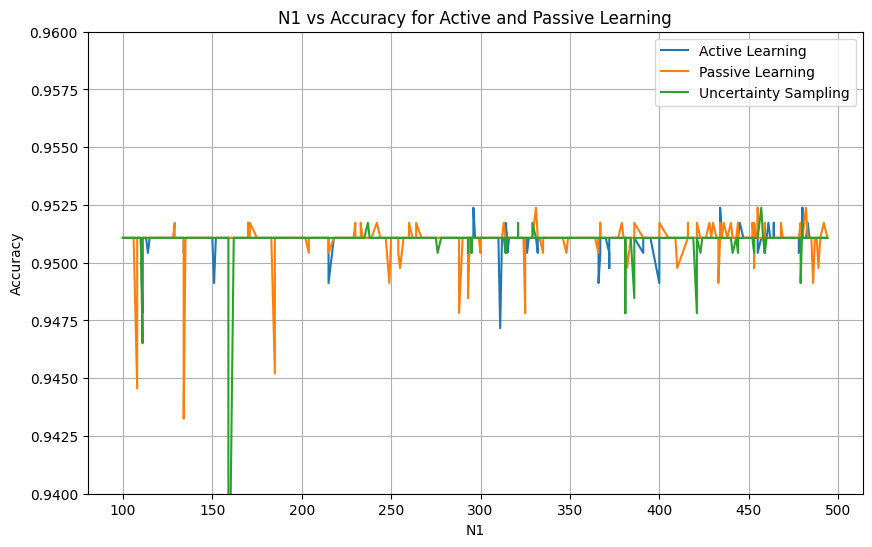

In [77]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n1_values_active_ns_lr, active_accuracies_ns_lr, label='Active Learning')
plt.plot(n1_values_passive_ns_lr, passive_accuracies_ns_lr, label='Passive Learning')
plt.plot(n1_values_us, us_accuracies, label='Uncertainty Sampling')
#plt.plot(n1_values_qbc, qbc_accuracies, label='Query By Committee')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('N1 vs Accuracy for Active and Passive Learning')
plt.legend()
plt.grid(True)
plt.ylim(0.94,0.96)
plt.show()

### SVC

done


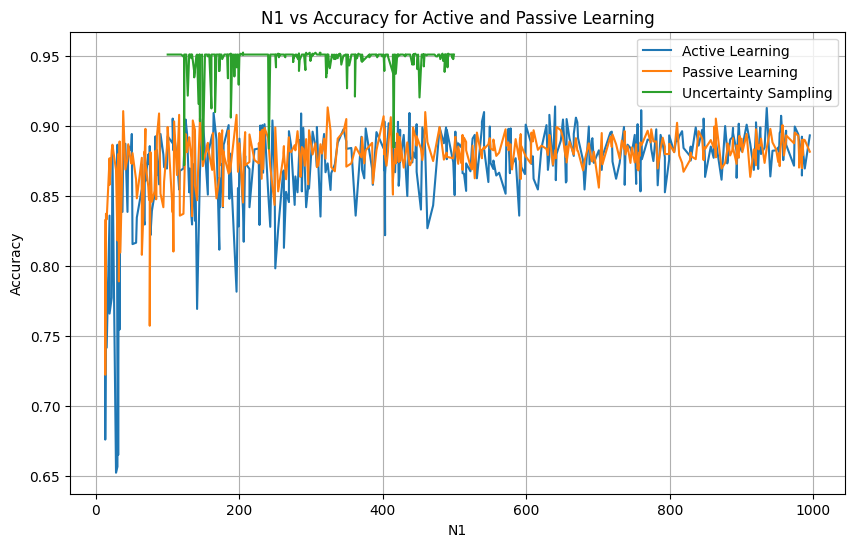

In [81]:
def evaluate_n1_active_svc_ns(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier_NS_SVC(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score

def evaluate_n1_passive_svc_ns(N1, X_train, y_train, X_test, y_test):
    indices = np.random.choice(len(X_train), size=N1, replace=False)
    X_train_sample = X_train[indices]
    Y_train_sample = y_train[indices]
    
    clf = SVC(probability=True, random_state=42)
    clf.fit(X_train_sample, Y_train_sample)
    predictions = clf.predict(X_test)
    score = accuracy_score(y_test, predictions)
    return N1, score

def evaluate_n1_us(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier_US_NS_SVC(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score


        
random_sizes = np.random.randint(100, 500, 400)
sorted_sizes = np.sort(random_sizes)
n1_values = sorted_sizes.tolist()


# Evaluate active learning in parallel
results_active_NS_SVC = Parallel(n_jobs=-1)(delayed(evaluate_n1_active_svc_ns)(N1, X_train_scaled, y_train, X_test_scaled, y_test) for N1 in n1_values)

# Evaluate passive learning in parallel
results_passive_NS_SVC = Parallel(n_jobs=-1)(delayed(evaluate_n1_passive_svc_ns)(N1, X_train_scaled, y_train, X_test_scaled, y_test) for N1 in n1_values)


results_ns_us_SVC=Parallel(n_jobs=-1)(delayed(evaluate_n1_us)(N1, X_train_scaled, y_train, X_test_scaled, y_test) for N1 in n1_values)
print("done")
#results_ns_qbc=Parallel(n_jobs=-1)(delayed(evaluate_n1_qbc)(N1,X_train_scaled, y_train, X_test_scaled, y_test) for N1 in n1_values)


# Extract results
# Extract results
n1_values_active_ns_svc, active_accuracies_ns_svc = zip(*results_active_NS_SVC)
n1_values_passive_ns_svc, passive_accuracies_ns_svc = zip(*results_passive_NS_SVC)

n1_values_us, us_accuracies = zip(*results_ns_us_SVC)
#n1_values_qbc, qbc_accuracies = zip(*results_ns_qbc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n1_values_active, active_accuracies, label='Active Learning')
plt.plot(n1_values_passive, passive_accuracies, label='Passive Learning')
plt.plot(n1_values_us, us_accuracies, label='Uncertainty Sampling')
#plt.plot(n1_values_qbc, qbc_accuracies, label='Query By Committee')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('N1 vs Accuracy for Active and Passive Learning')
plt.legend()
plt.grid(True)
plt.show()



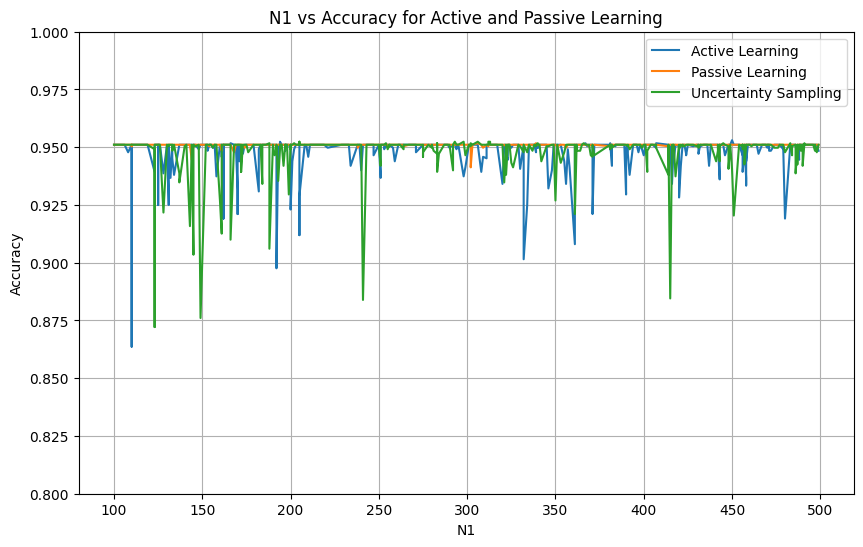

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(n1_values_active_ns_svc, active_accuracies_ns_svc, label='Active Learning')
plt.plot(n1_values_passive_ns_svc, passive_accuracies_ns_svc, label='Passive Learning')
plt.plot(n1_values_us, us_accuracies, label='Uncertainty Sampling')
#plt.plot(n1_values_qbc, qbc_accuracies, label='Query By Committee')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('N1 vs Accuracy for Active and Passive Learning')
plt.legend()
plt.ylim(0.8,1)
plt.grid(True)
plt.show()


### Decision Tree

done


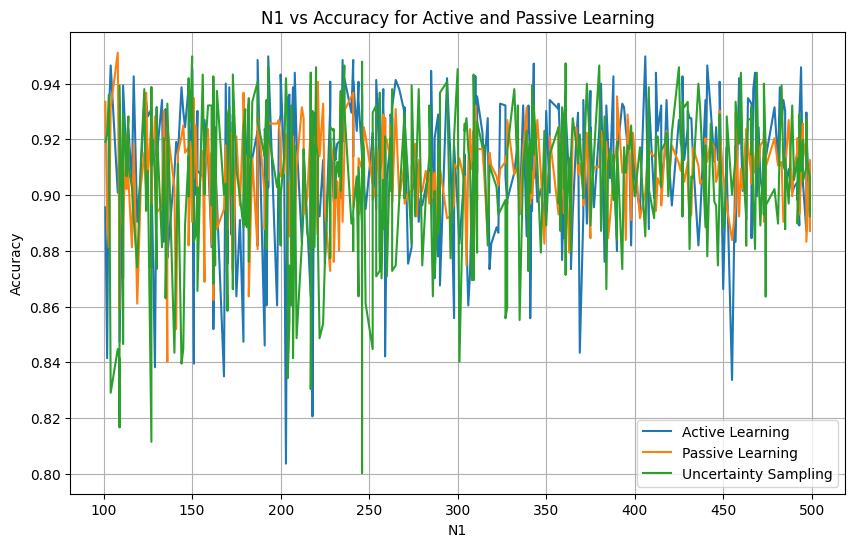

In [85]:
def evaluate_n1_active_dt_ns(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier_NS_DT(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score

def evaluate_n1_passive_dt_ns(N1, X_train, y_train, X_test, y_test):
    indices = np.random.choice(len(X_train), size=N1, replace=False)
    X_train_sample = X_train[indices]
    Y_train_sample = y_train[indices]
    
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train_sample, Y_train_sample)
    predictions = clf.predict(X_test)
    score = accuracy_score(y_test, predictions)
    return N1, score
def evaluate_n1_us(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier_US_NS_DT(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score


        
random_sizes = np.random.randint(100, 500, 400)
sorted_sizes = np.sort(random_sizes)
n1_values = sorted_sizes.tolist()



# Evaluate active learning in parallel
results_active_NS_dt = Parallel(n_jobs=-1)(delayed(evaluate_n1_active_dt_ns)(N1, X_train_scaled, y_train, X_test_scaled, y_test) for N1 in n1_values)

# Evaluate passive learning in parallel
results_passive_NS_dt = Parallel(n_jobs=-1)(delayed(evaluate_n1_passive_dt_ns)(N1, X_train_scaled, y_train, X_test_scaled, y_test) for N1 in n1_values)


results_ns_us_DT=Parallel(n_jobs=-1)(delayed(evaluate_n1_us)(N1, X_train_scaled, y_train, X_test_scaled, y_test) for N1 in n1_values)
print("done")
#results_ns_qbc=Parallel(n_jobs=-1)(delayed(evaluate_n1_qbc)(N1,X_train_scaled, y_train, X_test_scaled, y_test) for N1 in n1_values)



# Extract results
n1_values_active_ns_dt, active_accuracies_ns_dt = zip(*results_active_NS_dt)
n1_values_passive_ns_dt, passive_accuracies_ns_dt = zip(*results_passive_NS_dt)

n1_values_us, us_accuracies = zip(*results_ns_us_DT)
#n1_values_qbc, qbc_accuracies = zip(*results_ns_qbc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n1_values_active_ns_dt, active_accuracies_ns_dt, label='Active Learning')
plt.plot(n1_values_passive_ns_dt, passive_accuracies_ns_dt, label='Passive Learning')
plt.plot(n1_values_us, us_accuracies, label='Uncertainty Sampling')
#plt.plot(n1_values_qbc, qbc_accuracies, label='Query By Committee')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('N1 vs Accuracy for Active and Passive Learning')
plt.legend()
plt.grid(True)
plt.show()



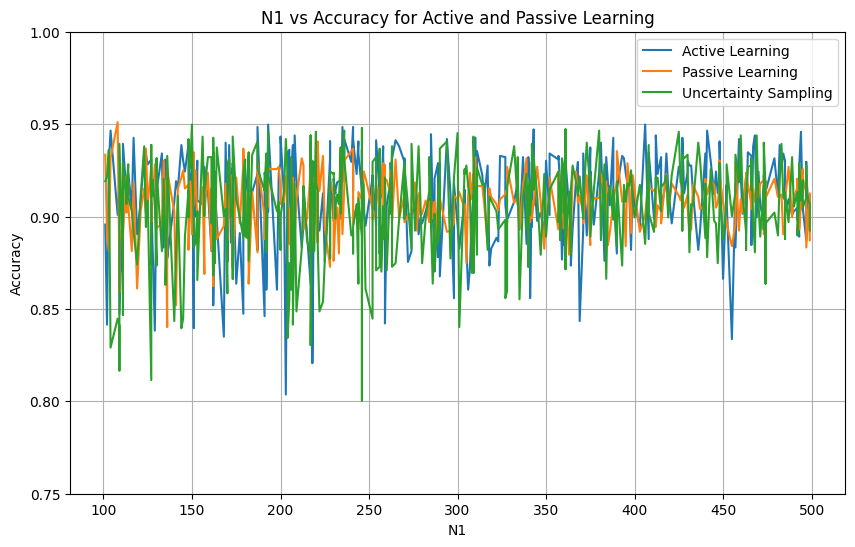

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(n1_values_active_ns_dt, active_accuracies_ns_dt, label='Active Learning')
plt.plot(n1_values_passive_ns_dt, passive_accuracies_ns_dt, label='Passive Learning')
plt.plot(n1_values_us, us_accuracies, label='Uncertainty Sampling')
#plt.plot(n1_values_qbc, qbc_accuracies, label='Query By Committee')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('N1 vs Accuracy for Active and Passive Learning')
plt.legend()
plt.grid(True)
plt.ylim(0.75,1)
plt.show()


# Hypertuning 

In [39]:
class ActiveLearningClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, beta=1, N1=500, d=2, c=1.5, M=100):
        self.beta = beta
        self.N1 = N1
        self.d = d
        self.c = c
        self.M = M
        self.epsilon = None
        self.A = None
        self.eta = None
        self.time_taken = None

    def fit(self, X_train, Y_train):
          # Replace with your instance space data if needed
        self.epsilon, self.A, self.eta, self.time_taken = active_learning_with_rejection(
            data=data, X_train=X_train, Y_train=Y_train, beta=self.beta, N1=self.N1, d=self.d, c=self.c, M=self.M
        )
        return self

    def predict(self, X_test):
        A_arrays = [np.array(sublist) for sublist in self.A]
        eta_values = np.zeros(len(X_test))

        for j in range(len(self.eta) - 1):
            mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
            eta_values[mask_j] += self.eta[j].predict_proba(X_test[mask_j])[:, 1]

        mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
        eta_values[mask_last] += self.eta[-1].predict_proba(X_test[mask_last])[:, 1]

        labels = (eta_values >= 0.5).astype(int)
        return labels

    def score(self, X_test, y_true):
        labels = self.predict(X_test)
        return accuracy_score(y_true, labels)

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'N1': self.N1,
            'd': self.d,
            'c': self.c,
            'M': self.M
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


## Fitting and Prediction

In [24]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(data[0], data[1])
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(data[0], data[1], test_size=0.2, random_state=42)
param_grid = {
    'beta': [0.5, 1,1.5 ],
    'N1': [300, 500,800,1000],
    'd': [2,3],
    'c': [1.0, 1.5],
    'M': [100, 150,200]
}

grid_search = GridSearchCV(ActiveLearningClassifier(), param_grid, cv=3,verbose=1,n_jobs=-1)
grid_search.fit(X_train3,Y_train3)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=ActiveLearningClassifier(), n_jobs=-1,
             param_grid={'M': [100, 150, 200], 'N1': [300, 500, 800, 1000],
                         'beta': [0.5, 1, 1.5], 'c': [1.0, 1.5], 'd': [2, 3]},
             verbose=1)

In [25]:
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test3)
accuracy = accuracy_score(Y_test3, Y_pred)
print(f'Accuracy: {accuracy}')
print(best_model.get_params())

Accuracy: 0.9833
{'beta': 1, 'N1': 800, 'd': 2, 'c': 1.5, 'M': 100}


## Confusion Matrix

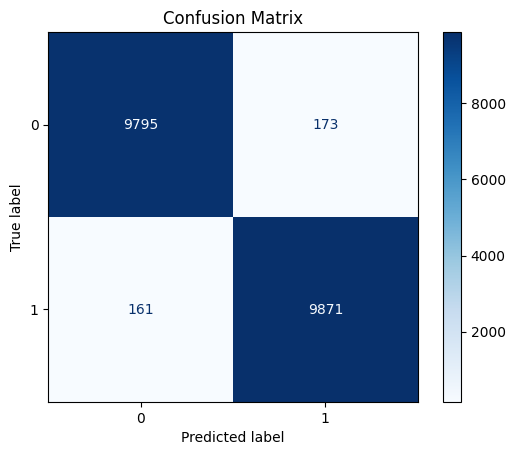

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test3, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

# Learning Curve

/home/kanupriya/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kanupriya/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/kanupriya/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/tmp/ipykernel_442770/3936332723.py", line 36, in score
  File "/tmp/ipykernel_442770/3936332723.py", line 27, in predict
  File "/home/kanupriya/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1431, in predict_proba
    return super()._predict_proba_lr(X)
  File "/home/kanupriya/.local/lib/python3.10/site-packages/sklearn/linear_model/_base.py", line 397, in _predict_pro

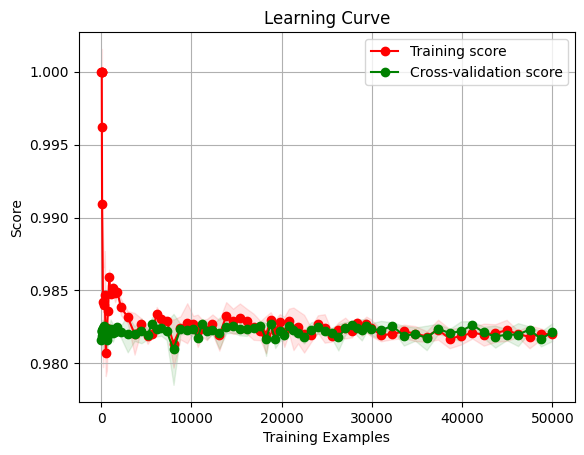

In [27]:
best_estimator = grid_search.best_estimator_

training_sizes = [10,50,100,500,1000,2000, 5000,7000, 10000,12000,15000,18000, 20000,22000,25000,28000, 30000,35000,40000,45000,50000]

new_list = np.interp(np.linspace(0, len(training_sizes) - 1, 80), np.arange(len(training_sizes)), training_sizes).astype(int)


train_sizes, train_scores, val_scores = learning_curve(
    best_estimator, X_train3, Y_train3, cv=3, n_jobs=-1, train_sizes=new_list
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')

plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()


/home/kanupriya/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:2050: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 88 instead of 100.
  warnings.warn(


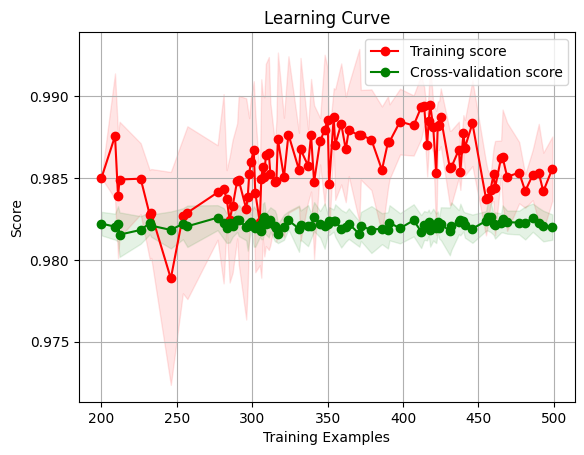

In [28]:
random_sizes2 = np.random.randint(200, 500, 100)
sorted_sizes = np.sort(random_sizes2)
training_sizes2 = sorted_sizes.tolist()

train_sizes2, train_scores2, val_scores2 = learning_curve(
    best_estimator, X_train3, Y_train3, cv=5, n_jobs=-1, train_sizes=training_sizes2
)

train_mean2 = np.mean(train_scores2, axis=1)
train_std2 = np.std(train_scores2, axis=1)
val_mean2 = np.mean(val_scores2, axis=1)
val_std2 = np.std(val_scores2, axis=1)

plt.figure()
plt.plot(train_sizes2, train_mean2, 'o-', color='r', label='Training score')
plt.plot(train_sizes2, val_mean2, 'o-', color='g', label='Cross-validation score')

plt.fill_between(train_sizes2, train_mean2 - train_std2, train_mean2 + train_std2, alpha=0.1, color='r')
plt.fill_between(train_sizes2, val_mean2 - val_std2, val_mean2 + val_std2, alpha=0.1, color='g')

plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()


In [29]:
from sklearn.model_selection import cross_val_score

/home/kanupriya/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


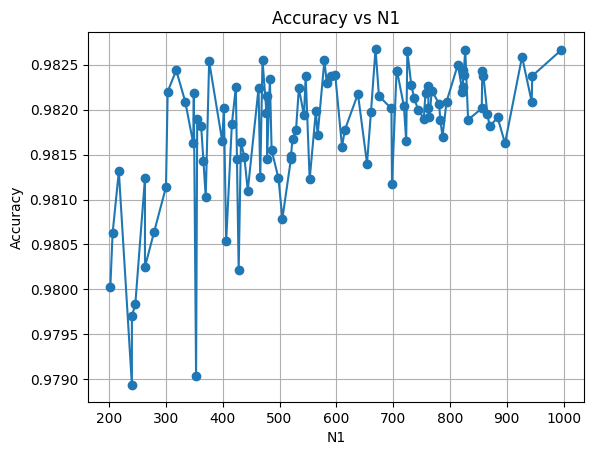

In [30]:
def evaluate_n1(N1, X, y, cv):
    clf = ActiveLearningClassifier(N1=N1)
    scores = cross_val_score(clf, X, y, cv=cv, n_jobs=-1)
    return N1, scores.mean()

random_sizes2 = np.random.randint(200, 1000, 100)
sorted_sizes = np.sort(random_sizes2)
n1_values = sorted_sizes.tolist()


cv_folds = 3
results = Parallel(n_jobs=-1)(delayed(evaluate_n1)(N1, X_train3, Y_train3, cv_folds) for N1 in n1_values)



n1_values, scores = zip(*results)
plt.plot(n1_values, scores, marker='o')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('Accuracy vs N1')
plt.grid(True)
plt.show()

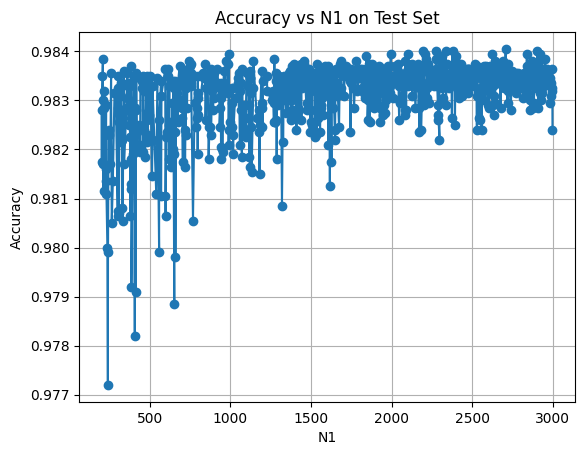

In [41]:
def evaluate_n1_test(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score

random_sizes2 = np.random.randint(200, 3000, 800)
sorted_sizes = np.sort(random_sizes2)
n1_values = sorted_sizes.tolist()


cv_folds = 3
results = Parallel(n_jobs=-1)(delayed(evaluate_n1_test)(N1, X_train3, Y_train3, X_test3, Y_test3) for N1 in n1_values)

n1_values, scores = zip(*results)
plt.plot(n1_values, scores, marker='o')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('Accuracy vs N1 on Test Set')
plt.grid(True)
plt.show()

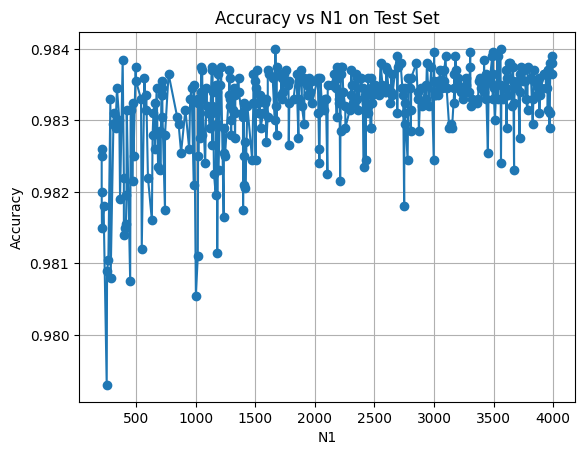

In [40]:
def evaluate_n1_test(N1, X_train, y_train, X_test, y_test):
    clf = ActiveLearningClassifier(N1=N1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return N1, score

random_sizes2 = np.random.randint(200, 4000, 400)
sorted_sizes = np.sort(random_sizes2)
n1_values = sorted_sizes.tolist()


cv_folds = 3
results = Parallel(n_jobs=-1)(delayed(evaluate_n1_test)(N1, X_train3, Y_train3, X_test3, Y_test3) for N1 in n1_values)

n1_values, scores = zip(*results)
plt.plot(n1_values, scores, marker='o')
plt.xlabel('N1')
plt.ylabel('Accuracy')
plt.title('Accuracy vs N1 on Test Set')
plt.grid(True)
plt.show()